< 1-3 paragraphs summary of README.md>

common ppt flow for introducing/explaining a machine learning model
1. problem statement
2. solution
3. explain the details


e.g.
one paragraph, explaining the context
one paragraph, purpose/objective of the notebook
=> so that the reader would know what this notebook/project is about.

------------------------------------------------------------------------------------------------------------------------
### Table of Content

0. Import functions

1. Load data

2. Explore data<br>
    2-1. Examine and transform data formats<br>
    2-2. Plot histograms and box plots<br>
    2-3. Plot a correlation heatmap<br>
    2-4. Plot seasonal decomposition<br>
    2-5. Plot autocorrelations

3. Select and engineer features

4. Train models<br>
    4-1. Split data into train and test sets<br>
    4-2. SARIMAX model<br>
    &emsp; 4-2-1. Perform stepwise search<br>
    &emsp; 4-2-2. Train with best orders<br>
    4-3. Train and evaluate different models<br>
    &emsp; 4-3-1. Train three different models<br>
    &emsp; 4-3-2. Compare model performance

5. Evaluate prediction results<br>
    5-1. Create Bollinger Bands<br>
    5-2. Get trading dates with different intervals<br>
    5-3. Make training decisions and get capital returns

6. Build pipeline and process all stock data

7. Conclusion
------------------------------------------------------------------------------------------------------------------------

### <b>0. Import Functions</b>

In [89]:
import sys
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pmdarima.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX

from utils.load import load_dataframes
from utils.transform import convert_vol_to_float, seasonal_decomposition, add_features_from_previous_dates,\
                            create_bollinger_band
from utils.plot import plot_histograms, plot_heatmap, plot_autocorrelation, plot_bollinger_band
from utils.predict import train_models_and_make_predictions, get_trading_decision_and_results
from utils.evaluate import evaluate_predictions
from utils.pipeline import process_df

import warnings
warnings.simplefilter('ignore', UserWarning)

### <b>1. Load data</b>

In [90]:
# Assign details of the source file in G Drive to local variables.
base_url = 'https://drive.google.com/file/d/'
file_id = '1MiunF_O8eNWIcfaOA4PVm668RN7FgLNA0a6U4LWf5Bk'
file_url = f'{base_url}{file_id}'
file_name = '2020Q1Q2Q3Q4-2021Q1.xlsx'

# Assign details of local directories to local variables.
root_dir = sys.path[0]
download_dir = Path(root_dir) / 'data'
file_path = download_dir / file_name

# Download the file if it's not found in the file path.
if os.path.exists(file_path):
    print(f'File {file_name} already exists in {download_dir}.')
else:
    if os.getcwd() != download_dir:
        os.chdir(download_dir)
    print(f'File {file_name} is not found in {download_dir}.')
    !gdown 1MiunF_O8eNWIcfaOA4PVm668RN7FgLNA0a6U4LWf5Bk

# Move back to the root directory.
if os.getcwd() != root_dir:
    os.chdir(root_dir)

File 2020Q1Q2Q3Q4-2021Q1.xlsx already exists in d:\OneDrive\GitHub\Apziva\FAxAtx2ZjFTGstEu\data.


In [91]:
full_sheet_names = [
    'Russia - Sberbank Rossii PAO (SBER)',
    'Turkey - Koc Holding AS (KCHOL)',
    'Egypt - Medinet Nasr Housing (MNHD)',
    'Brazil - Minerva SA/Brazil (BEEF3)',
    'Argentina - Pampa Energia SA (PAMP)',
    'Colombia - Cementos Argos SA (CCB)',
    'South Africa - Impala Platinum Holdings Ltd (IMPJ)',
    'South Korea - Dongkuk Steel Mill Co Ltd (001230)'
]
data_dfs = load_dataframes(file_path, full_sheet_names)

8 DataFrames loaded with the following sheet names:

Russia - Sberbank Rossii PAO (SBER)
Turkey - Koc Holding AS (KCHOL)
Egypt - Medinet Nasr Housing (MNHD)
Brazil - Minerva SA/Brazil (BEEF3)
Argentina - Pampa Energia SA (PAMP)
Colombia - Cementos Argos SA (CCB)
South Africa - Impala Platinum Holdings Ltd (IMPJ)
South Korea - Dongkuk Steel Mill Co Ltd (001230)


### <b>2. Explore data</b>

#### <b>2-1. Examine and transform data formats</b>

We have loaded 8 DataFrames (for 8 different stocks). The format of each of the DataFrames should be the same.<br>
Let's have a look at the first one.

In [92]:
first_df = data_dfs[full_sheet_names[0]]
print('Basic info of the first DateFrame:\n')
print(first_df.info())
print('\n')
print('Tail of the first DataFrame:\n')
print(first_df.tail())

Basic info of the first DateFrame:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 311 entries, 0 to 310
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      311 non-null    datetime64[ns]
 1   Price     311 non-null    float64       
 2   Open      311 non-null    float64       
 3   High      311 non-null    float64       
 4   Low       311 non-null    float64       
 5   Vol.      311 non-null    object        
 6   Change %  311 non-null    float64       
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 17.1+ KB
None


Tail of the first DataFrame:

          Date   Price    Open    High     Low    Vol.  Change %
306 2020-01-10  258.19  257.86  259.25  256.88  18.85M    0.0008
307 2020-01-09  257.99  259.40  261.76  257.01  38.33M   -0.0045
308 2020-01-08  259.15  253.57  259.15  253.03  40.82M    0.0207
309 2020-01-06  253.90  254.75  254.84  251.40  22.35M   -0.0043
310 2020-01-

- Since we have time-series data, we will set the 'Date' column as index.
- The dtype of the 'Vol.' column is object, which needs to be converted to either integer or float so that the values are machine-readable, in other words so that they can be used as a training feature.
- Additionally, the 'Price' column will be the target to be predicted, which is the closing price for each trading date.

In [93]:
df = first_df.set_index('Date').sort_index()
df['Vol.'] = df['Vol.'].apply(convert_vol_to_float)
df

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2020-01-03,255.00,255.99,258.19,253.70,35850000.0,0.0010
2020-01-06,253.90,254.75,254.84,251.40,22350000.0,-0.0043
2020-01-08,259.15,253.57,259.15,253.03,40820000.0,0.0207
2020-01-09,257.99,259.40,261.76,257.01,38330000.0,-0.0045
2020-01-10,258.19,257.86,259.25,256.88,18850000.0,0.0008
...,...,...,...,...,...,...
2021-03-25,286.66,286.50,287.03,283.85,35220000.0,0.0030
2021-03-26,291.22,288.63,292.75,288.32,56070000.0,0.0159
2021-03-29,293.30,289.72,294.09,289.26,43680000.0,0.0071


#### <b>2-2. Plot histograms and box plots</b>

To understand the distribution of each column, let's plot a histogram and a box plot for each column.

Distribution of target 'Price' and dependent variables:


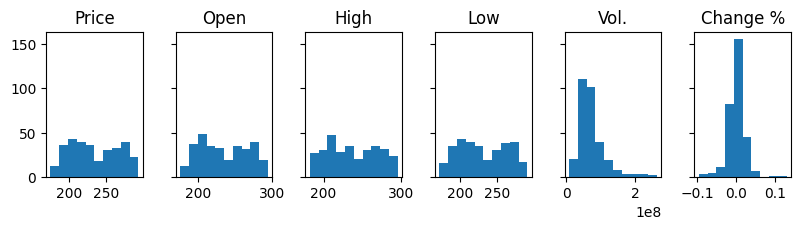

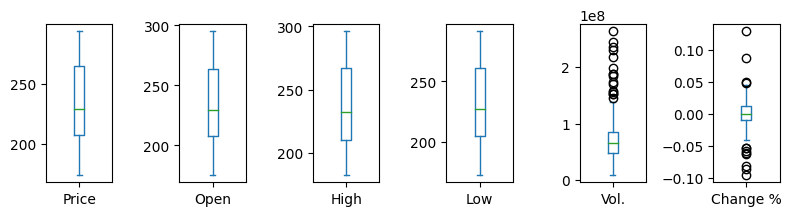

In [94]:
plot_histograms(data=df,
                target='Price', target_figsize=(2,2),
                dependent_layout=(2,9), dependent_figsize=(12, 4),
                include_boxplots=True)

- The 'Vol.' column is right-skewed.
- The 'Change %' column is roughly normally distributed.
- The 'Vol.' and 'Change %' columns have many outliers. 
- The other columns show bimodal distributions without outliers.

#### <b>2-3. Plot a correlation heatmap</b>

A correlation heatmap shows how closely different variables are related to each other. What we want to learn from plotting a correlation heatmap is what columns (or variables, features) are more closely related to the target column 'Price' - the higher the correlation coefficient is, the more closely related the two columns are. Those columns with a high correlation coefficient with the target would be more helpful in predicting the target values.

,Price,Open,High,Low,Vol.,Change %
Price,1.000000,0.992246,0.996541,0.995765,-0.245279,0.089939
Open,0.992246,1.000000,0.996392,0.996370,-0.262197,-0.014046
High,0.996541,0.996392,1.000000,0.994497,-0.215092,0.034574
Low,0.995765,0.996370,0.994497,1.000000,-0.291138,0.037396
Vol.,-0.245279,-0.262197,-0.215092,-0.291138,1.000000,0.044594
Change %,0.089939,-0.014046,0.034574,0.037396,0.044594,1.000000


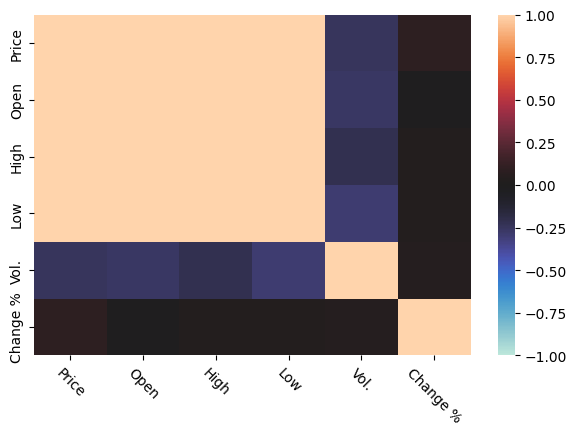

In [95]:
plot_heatmap(df.corr(), figsize=(6, 4), rotate_xticks=-45, corr_df=True, vmin=-1, vmax=1, center=0)
df.corr()

- The correlation between the 'Change %' and the target (i.e. 'Price') column is very low - less than 0.1.
- The correlation between the 'Vol.' and 'Price' columns is also pretty low - the absolute value of it is less than 0.3.
- Thus, these two columns would not be very useful in training a predictive model.

#### <b>2-4. Plot seasonal decomposition</b>

Since we have time series data, we'd like to identify seasonalities in the data. To do so, we will use the STL method.

STL (Seasonal and Trend decomposition using LOESS) is a versatile and robust method for decomposing time series, as it can capture general patterns without making assumptions about data. This is possible thanks to LOESS (Locally Estimated Scatterplot Smoothing), a nonparametric method where no assumptions are made about the underlying structure of a series of data for estimating nonlinear relationships. It uses local regression to fit a smooth curve through a scatterplot of data.

Plotting seasonal componets:


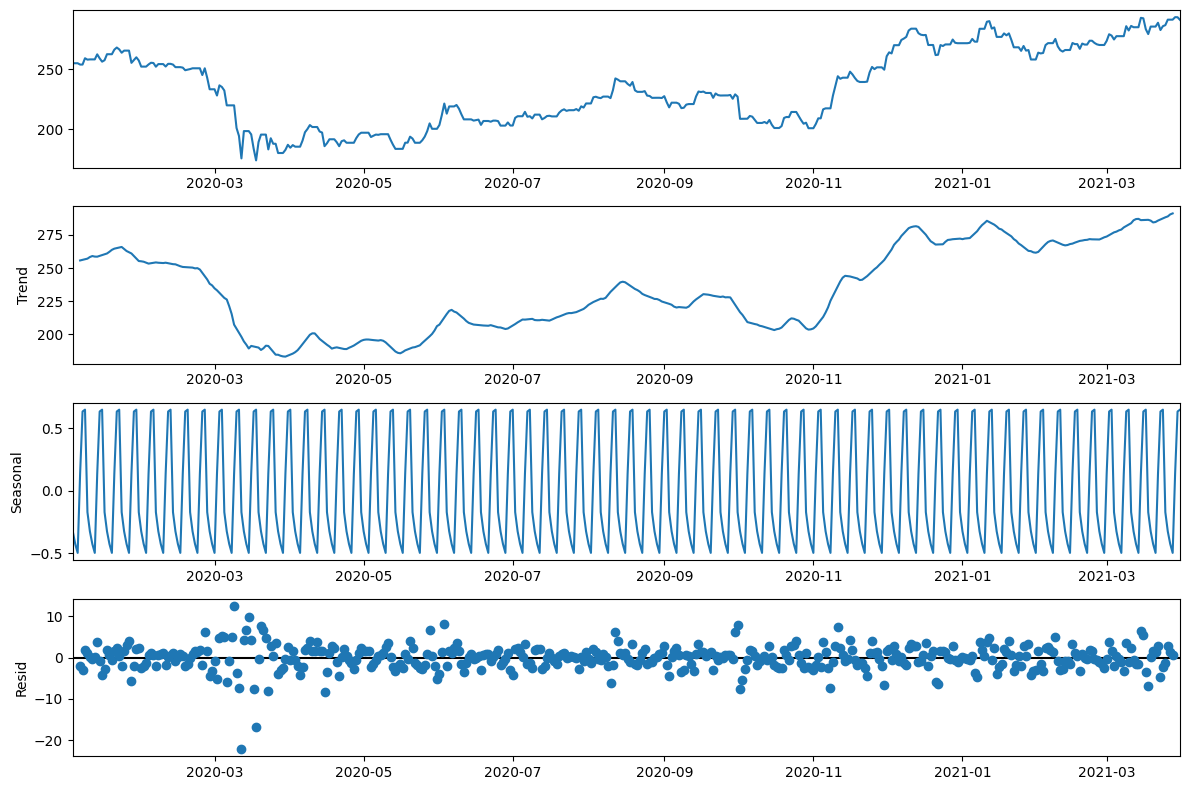

In [96]:
seasonal_decomposition(df=df, frequency='D', column='Price', add_to_df=False, plot=True)

- The original data and the Trend component (i.e., the first and second plots) look very similar, indicating seasonality in the time series data is not significant.
- The patterns observed from the Seasonal plot are likely due to the regularity of the trading dates. For instance, there's no trading data on weekends. The repeating patterns would also be because STL does not account for trading days or calendar variations.
- Most residuals (i.e., the Resid plot) are centered around 0, and there's only a small number of data points with absolute values greater than 10.

#### <b>2-5. Plot autocorrelations</b>

To see how similar the current data point is to historical data, we will look at autocorrelation and partial autocorrelation.

The ACF (Auto-Correlation Function) returns autocorrelations over time where variability can be explained by multiple points in time.

The PACF (Partial ACF) returns partial autocorrelation for each point in time, that is, only the additional autocorrelation between the current and previous points in time.

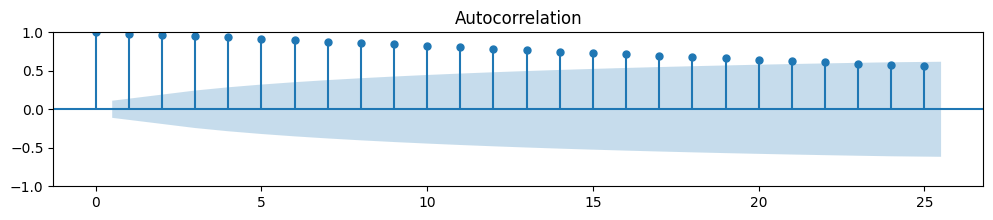

In [97]:
plot_autocorrelation(df, 'Price', partial=False)

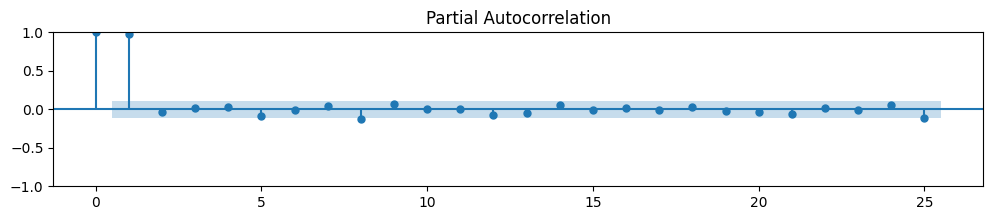

In [98]:
plot_autocorrelation(df, 'Price', partial=True)

The next day (i.e., where the X value in the plot is 1) has an autocorrelation of almost 1, meaning only the previous day would be relevant to today. To put it differently, most past data except for yesterday's data may not be helpful in predicting today's data, in our case today's closing price (i.e., the 'Price' column).

The blue area in the ACF and PACF plots depicts the 95% confidence interval, meaning anything within the blue area is statistically close to zero and anything outside the blue area is statistically non-zero.

### <b>3. Select and engineer features</b>

Based on what we have observed from the previous steps, we can decide the following:

- 'Vol.' and 'Change %' are not relevant based on correlation coefficients with the target column 'Price', so they will be dropped for the next steps.
- Only the previous date's price is highly correlated with today's price based on autocorrelation, but simple moving averages over the week will also be used as training features in addition to the data from the previous date so that trends can be captured and learned by the model.

In [99]:
concat_df = add_features_from_previous_dates(df)

# Drop the target column and the columns that will not be available when making predictions
X = concat_df.drop(['Price'], axis=1)
print("Training features:")
print(*list(X.columns), sep='\n')

y = concat_df['Price']
print("\nTarget: Price")

Training features:
Price (Day-1)
Open (Day-1)
High (Day-1)
Low (Day-1)
2 Day SMA Price (Day-1)
3 Day SMA Price (Day-1)
4 Day SMA Price (Day-1)
5 Day SMA Price (Day-1)
6 Day SMA Price (Day-1)
7 Day SMA Price (Day-1)

Target: Price


All training features are highly correlated with the target 'Price' according to the correlation heatmap below.

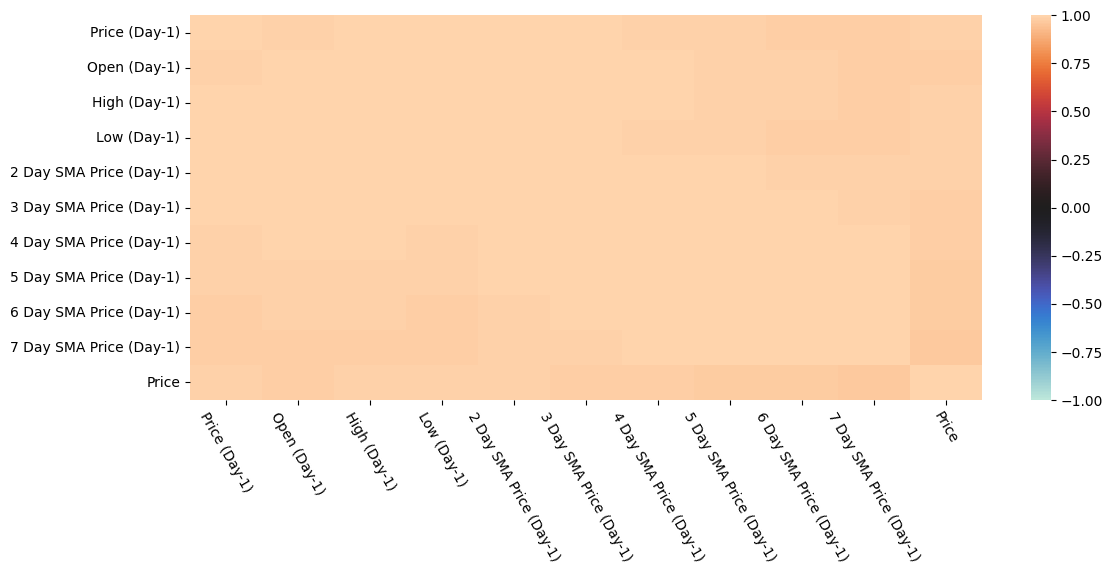

In [100]:
plot_heatmap(pd.concat([X, y], axis=1).corr(), figsize=(12, 6), rotate_xticks=-60, corr_df=True,
             vmin=-1, vmax=1, center=0)

### <b>4. Train models</b>

#### <b>4-1. Split data into train and test sets</b>

The train data set will be from 2020 and the test set from 2021.

In [101]:
X_train = X[X.index.year == 2020]
X_test = X[X.index.year == 2021]

y_train = y[y.index.year == 2020]
y_test = y[y.index.year == 2021]

#### <b>4-2. SARIMAX model</b>

SARIMAX (Seasonal AutoRegressive Integrated Moving Average with eXogenous variables) is a versatile time series model that considers both non-seasonal and seasonal components, as well as exogenous variables. It is particularly useful when dealing with time series data that exhibits seasonality and requires differencing to achieve stationarity. The model leverages autoregressive, differencing, and moving average terms to capture the underlying patterns and make forecasts.

In a SARIMAX model, the time series is assumed to have both non-seasonal and seasonal components. The non-seasonal component is captured by the ARIMA model, while the seasonal component is captured by the seasonal ARIMA (SARIMA) model. The inclusion of exogenous (the 'X' in SARIMAX) variables allows for the incorporation of additional factors that may influence the time series.

A SARIMAX model is typically denoted as SARIMAX (p, d, q) (P, D, Q, s), where:
- p, d, and q are the orders of the non-seasonal AR (i.e. the number of autoregressive terms), differencing (i.e. the number of non-seasonal differences needed for stationarity), and MA (i.e. the number of lagged forecast errors in the prediction equation) components, respectively.
- P, D, Q, and s are the orders of the seasonal AR, differencing, MA components, and the seasonal period, respectively.
- Exogenous variables can be included in the model by specifying them separately.

\* Further breakdown of the terms related to SARIMAX

1. Stationarity:
A stationary time series is one whose statistical properties (e.g., mean, variance) remain constant over time. In a non-stationary time series, these properties change over time, making it difficult to model and predict. To make the time series stationary, we often take the difference between consecutive observations, known as differencing. This helps to remove trends and seasonality, making the data more amenable to modeling.

2. Autoregressive (AR) Terms:
The autoregressive component of the SARIMAX model refers to the relationship between the current value of the time series and its past values. In other words, the value at a given time point is modeled as a linear combination of the previous observations with appropriate coefficients. The "AR(p)" term indicates the number of past observations (lags) considered in the model.

3. Differencing Terms (I - Integrated):
The "I" in SARIMAX stands for integrated, which relates to the differencing mentioned earlier. The integration order "d" represents the number of times differencing is applied to achieve stationarity. If "d=1", it means one level of differencing was used, and if "d=2", it means the series was differenced twice, and so on.

4. Moving Average (MA) Terms:
The moving average component of the SARIMAX model accounts for the relationship between the current value of the time series and the past forecast errors. The "MA(q)" term indicates the number of past forecast errors considered in the model.

5. Seasonal Components (S):
Many time series exhibit seasonal patterns, such as quarterly sales, monthly temperature variations, etc. SARIMAX models account for these seasonal patterns using seasonal autoregressive and moving average terms. The seasonal autoregressive term is denoted by "SAR(P)", and the seasonal moving average term is denoted by "SMA(Q)". The capital letters "P" and "Q" represent the seasonal autoregressive and moving average orders, respectively.

6. Exogenous Variables (X):
The "X" in SARIMAX denotes that this model allows for the inclusion of exogenous variables. Exogenous variables are additional input variables that may influence the time series but are not affected by it. These variables can improve the model's forecasting accuracy by capturing external factors that impact the time series.

##### 4-2-1. Perform stepwise search

Before modeling, we'd like to know the best orders with the smallest AIC. To do so, we will use the stepwise search using the auto_arima function.

The AIC (Akaike's information Criterion) is a widely used measure of a statistical model. This metric quantifies the goodness of fit and simplicity of the model into a single statistic. When comparing two models, the one with the lower AIC is considered to be better.

In [102]:
search_result=auto_arima(y_train, 
                    exogenous= X_train,
                    start_p=1, max_p=7, 
                    start_q=1, max_q=7, 
                    d=1, max_d=7,
                    trace=True, 
                    error_action='ignore', 
                    suppress_warnings=True, 
                    stepwise=True)
search_result.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1464.557, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1461.760, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1463.283, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1463.233, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1459.800, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.321 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  243
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -728.900
Date:                Tue, 25 Jul 2023   AIC                           1459.800
Time:                        20:45:08   BIC                           1463.289
Sample:                             0   HQIC                          1461.206
                                - 243                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2        24.1937      1.313     18.428      0.000      21.620      26.767
===================================================================================
Ljung-Box (L1) (Q):                   0.49   Jarque-Bera (JB):               134.83
Prob(Q):                              0.49   Prob(JB):                         0.00
Heteroskedasticity (H):               0.50   Skew:                            -0.24
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

##### 4-2-2. Train with best orders

Use the best orders found from the stepwise search to train a SARIMAX model.

                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                  243
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -716.458
Date:                Tue, 25 Jul 2023   AIC                           1454.916
Time:                        20:45:08   BIC                           1493.294
Sample:                             0   HQIC                          1470.376
                                - 243                                         
Covariance Type:                  opg                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Price (Day-1)               0.0015      0.152      0.010      0.992      -0.296       0.299
Open (Day-1)               -0.2741      0.146     -1.883      0.060      -0.559       0.011


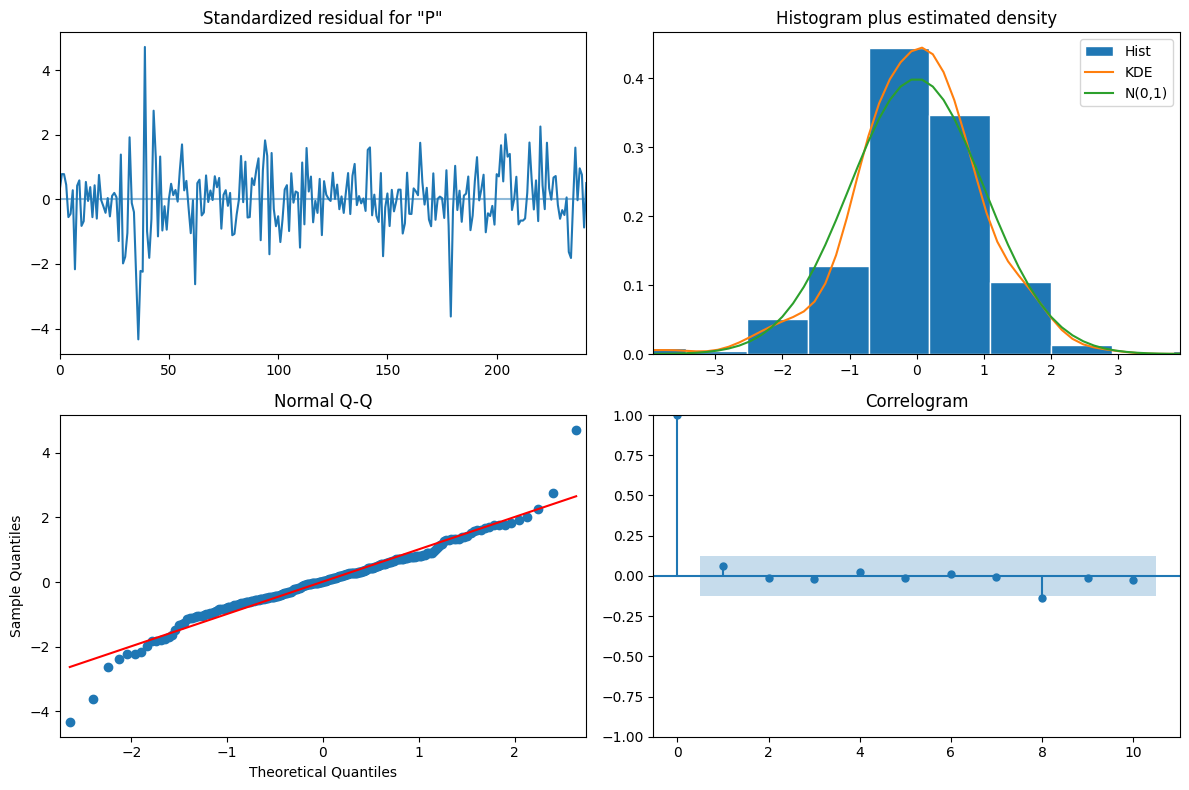

In [103]:
sarimax_model = SARIMAX(
    endog = y_train,
    exog = X_train,
    order=search_result.order, # (0, 1, 0)
    seasonal_order=search_result.seasonal_order # (0, 0, 0, 0)
    )
fit_result = sarimax_model.fit(disp=False)
print(fit_result.summary())

fit_result.plot_diagnostics(figsize=(12, 8))
plt.tight_layout()
plt.show()

The plot_diagnostics method produces a 2x2 plot grid with the following plots (ordered clockwise from top left):
1. Standardized residuals over time
2. Histogram plus estimated density of standardized residuals, along with a Normal (0,1) density plotted for reference
3. Normal Q-Q plot, with Normal reference line
4. Correlogram

#### <b>4-3. Train and evaluate different models</b>

##### 4-3-1. Train three different models

The SARIMAX model above might work well but try training two other models (that is, random forest and XGB regressors, both of which are widely used) just in case it doesn't work as expected.

For training, the whole train data and part of the test data will be used at each step (i.e. for each row) so that the time series predictions can be more timely, thus more accurate. For example, to make a prediction for the date of Jan 5, 2021, the whole data from 2020 plus the data up to Jan 4, 2021 (if it exists in the data set) will be used for training.

In [104]:
random_state = 5
preds_df = train_models_and_make_predictions(X_train, y_train, X_test, y_test, random_state)
preds_df.head()

  0%|          | 0/61 [00:00<?, ?it/s]

100%|██████████| 61/61 [01:10<00:00,  1.16s/it]


,Price,SARIMAX,RandomForestRegressor,XGBRegressor
Date,,,,
2021-01-04,272.00,272.065064,267.438770,277.448181
2021-01-05,275.20,273.228012,267.903785,272.790466
2021-01-06,272.93,275.635722,268.368358,275.882263
2021-01-08,283.64,272.224619,268.884473,274.682220
2021-01-11,289.49,286.083463,269.907792,282.125916


##### 4-3-2. Compare model performance

To evaluate and compare model performance, we will use three different evaluation metrics (that is, mean squared error, mean absolute percentage error, and R2 score) and a line plot.

,Model,Mean Squared Error,Mean Absolute Percentage Error,R2 Score
0,SARIMAX,19.376120,0.012779,0.765763
2,XGBRegressor,37.454176,0.018158,0.547218
1,RandomForestRegressor,95.672374,0.027844,-0.156579


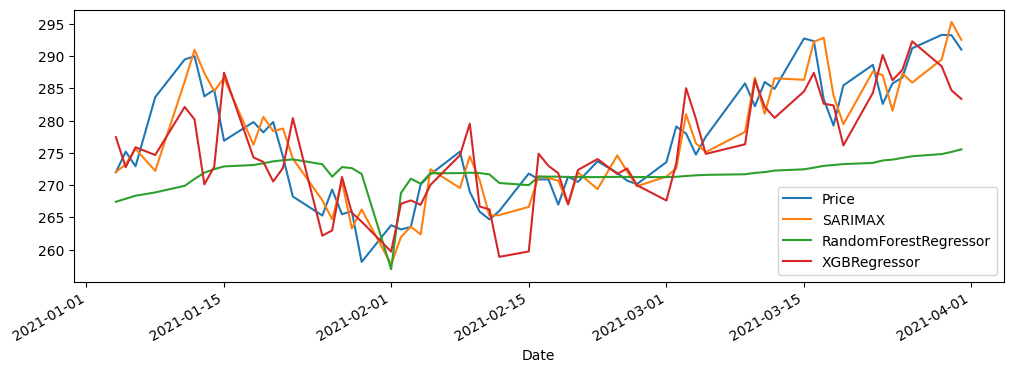

In [105]:
evaluate_predictions(y_test, preds_df,
                     keys=['SARIMAX', 'RandomForestRegressor', 'XGBRegressor'], plot_df=True)

The predictions from both the SARIMAX and XGBRegressor seem to be close to the target 'Price' according to the line plot above.<br>

However, the SARIMAX model's predictions were a lot better based on the three evaluation metrics used - i.e. smaller mean squared error, smaller mean absolute percentage error, and greater R2 score.<br>

Hence, the SARIMAX model's predictions will be used to make trading decisions on the next steps.

### <b>5. Evaluate prediction results</b>

#### <b>5-1. Create Bollinger Bands</b>

Bollinger Bands are a type of price envelope developed by John Bollinger. A price envelope consists of lower and upper bands placed against a moving average line. Typically, Bollinger Bands uses a 20-period (20-day in our case) moving average, and the upper and lower bands would be two standard deviations above and below the moving average.

Bollinger Bands are a technical indicator that helps traders identify a probable price turnaround. The most common strategy using Bollinger Bands is to sell when the price goes below the lower band and to buy when the price goes above the upper band, because the price is not likely to deviate further away from the lower and upper bands - that is, the price will revert to the long-term trend, which is the simple moving average ± standard deviations.

Therefore, these will be our strategy in making trading decisions based on the predicted price and Bollinger Bands:

- If the predicted price is lower than the lower bound, the trading decision will be 'buy.'
- If the predicted price is higher than the upper bound, the trading decision will be 'sell.'
- If the predicted price is within the Bands, the trading decision will be 'hold.'


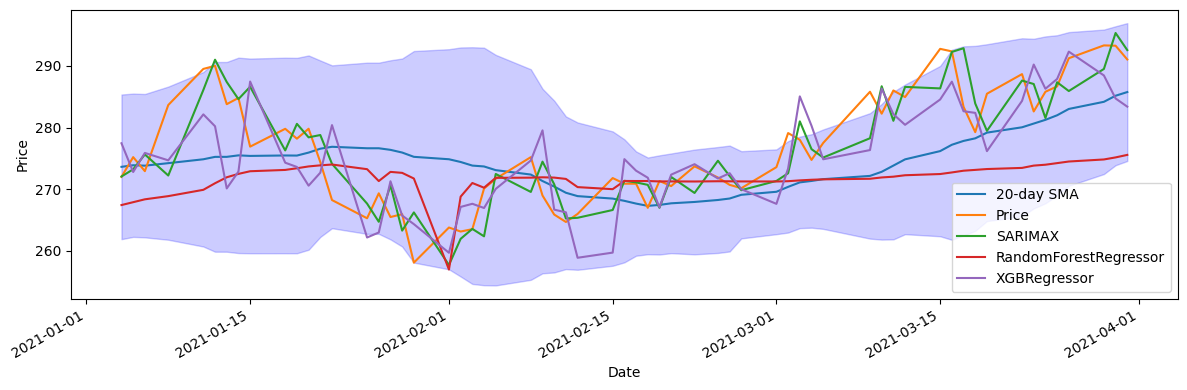

In [106]:
bollinger_band_window=20
bollinger_band_std=2

rolling_mean, upper_band, lower_band = create_bollinger_band(y, y_test, bollinger_band_window, bollinger_band_std)

plot_bollinger_band(rolling_mean, bollinger_band_window, upper_band, lower_band, y_test,
                    additional_df=preds_df, xlabel='Date', ylabel='Price')

In the above visualization, Bollinger Bands are the area filled in light purple.

We might need to adopt a smaller standard deviation for the upper and lower bands or use a different period for the simple moving average because the standard Bollinger Bands (i.e., 2 standard deviations above and below 20-day SMA) wrapped almost all predicted prices, meaning the vast majority of the trading decisions will be 'hold', which we want to avoid.

#### <b>5-2. Get trading dates with different intervals</b>

Get daily, weekly, and monthly trading dates for making trading decisions on a daily, weekly, and monthly basis.

In [107]:
daily_trading_dates = y_test.index # Trade every 1 trading day
weekly_trading_dates = y_test.index[np.arange(5, len(y_test), 5)] # Trade every 5 trading days
monthly_trading_dates = y_test.index[np.arange(20, len(y_test), 20)] # Trade every 20 trading days

#### <b>5-3. Make training decisions and get capital returns</b>

Now we are going to make trading decisions based on the SARIMAX model's predicted Price and Bollinger Bands. We will also estimate capital returns following the trading decisions.

Before moving forward, for an easier view and evaluation of the results, let's create a data frame with the relevant columns.

In [108]:
y_pred = preds_df['SARIMAX'].rename('Predicted')

results_df = pd.concat([
    df[['Price', 'Open', 'High', 'Low']],
    y_pred,
    rolling_mean.rename('20-day SMA'),
    upper_band,
    lower_band
    ],
    axis=1).dropna()
results_df.head()

,Price,Open,High,Low,Predicted,20-day SMA,Upper Band,Lower Band
Date,,,,,,,,
2021-01-04,272.00,274.67,276.60,270.61,272.065064,273.6285,285.342686,261.914314
2021-01-05,275.20,272.69,275.70,270.28,273.228012,273.8885,285.493915,262.283085
2021-01-06,272.93,275.94,275.94,271.62,275.635722,273.8170,285.427803,262.206197
2021-01-08,283.64,275.11,283.99,275.11,272.224619,274.2245,286.627575,261.821425
2021-01-11,289.49,282.86,292.95,279.48,286.083463,274.8545,288.987067,260.721933


##### 5-3-1. Make trading decisions based on Bollinger Band

- sell at Open price if the previous trading date's high was above the upper band
- buy at Open price if the previous trading date's low was below the lower band 
- hold otherwise

In [110]:
bollinger_band_windows = [5, 10, 20] # For daily, weekly, and monthly (e.g. 10, 20, 50)
bollinger_band_stds = [0.5, 0.5, 1]   # For daily, weekly, and monthly (e.g. 1.5, 2, 2.5)
initial_balance = 10000
initial_no_stock = 0
max_no_stock_to_trade = 1

get_trading_decision_and_results(y, y_test, preds_df['SARIMAX'].rename('Predicted'),
                                 bollinger_band_windows, bollinger_band_stds,
                                 df, initial_balance, initial_no_stock, max_no_stock_to_trade,
                                 daily_trading_dates, weekly_trading_dates, monthly_trading_dates,
                                #  use_pred=True, pred_col='Predicted'
                                 )

Buy 1 stock(s) at 274.67.
Sell 1 stock(s) at 272.69.
Buy 1 stock(s) at 275.94.
Sell 1 stock(s) at 275.11.
Hold. The price range is within the Bollinger Band.
Hold. The price range is within the Bollinger Band.
Hold. The price range is within the Bollinger Band.
Hold. The price range is within the Bollinger Band.
Buy 1 stock(s) at 282.55.
Buy 1 stock(s) at 275.72.
Buy 1 stock(s) at 280.98.
Sell 1 stock(s) at 278.62.
Sell 1 stock(s) at 280.75.
Sell 1 stock(s) at 273.0.
Buy 1 stock(s) at 271.0.
Buy 1 stock(s) at 262.7.
Buy 1 stock(s) at 270.07.
Sell 1 stock(s) at 263.5.
Buy 1 stock(s) at 263.77.
Buy 1 stock(s) at 260.0.
Buy 1 stock(s) at 265.0.
Sell 1 stock(s) at 264.32.
Sell 1 stock(s) at 263.21.
Sell 1 stock(s) at 271.99.
Sell 1 stock(s) at 273.01.
Sell 1 stock(s) at 275.99.
Buy 1 stock(s) at 269.28.
Buy 1 stock(s) at 265.5.
Buy 1 stock(s) at 264.0.
Buy 1 stock(s) at 268.49.
Sell 1 stock(s) at 272.3.
Sell 1 stock(s) at 270.99.
Sell 1 stock(s) at 270.35.
Sell 1 stock(s) at 266.12.
Buy 1 

,Capital Return,Remaining Stock,Last Closing Price
Daily Trading,58.66,0.0,291.02
Weekly Trading,21.20,0.0,291.02
Monthly Trading,51.11,0.0,291.02


##### 5-3-2. Make trading decisions based on predictions


Here are some important things to note about the process:

- the following values can be specified:
    - initial_balance: the balance before the first trading date. default 0
    - initial_no_stock: the number of stock before the first trading date. default 0
    - max_no_stock_to_trade: the maximum number of stocks to trade at once (or on a single trading date)

- trading is done on a daily, weekly, and monthly basis separately, so is the capital return calculated separately.


- Trading criteria:
    - the default trading decision is 'Hold'.

    - if the predicted price (i.e. the 'Predicted' column value) is greater than the upper band, sell the holding stocks up to the maximum number as specified by the max_no_stock_to_trade argument. Additionally, also sell the holding stocks up to the all stocks if that would not make a loss.
    - Do not sell any stocks if that will make a loss.

    - if the predicted price is less than the lower band, buy stocks up to the maximum number as specified by the max_no_stock_to_trade argument.
    - Do not buy any stocks if that will make the balance go negative.

Capital returns from trading decisions based on the Bollinger Bands (i.e. a 20-day Simple Moving Average with a standard diviation of 0 in our case) and the 'Predicted (Price)'.

In [111]:
bollinger_band_windows = [5, 10, 20] # For daily, weekly, and monthly (e.g. 10, 20, 50)
bollinger_band_stds = [0.5, 0.5, 1]   # For daily, weekly, and monthly (e.g. 1.5, 2, 2.5)
initial_balance = 10000
initial_no_stock = 0
max_no_stock_to_trade = 1

get_trading_decision_and_results(y, y_test, preds_df['SARIMAX'].rename('Predicted'),
                                 bollinger_band_windows, bollinger_band_stds,
                                 df, initial_balance, initial_no_stock, max_no_stock_to_trade,
                                 daily_trading_dates, weekly_trading_dates, monthly_trading_dates,
                                 use_pred=True, pred_col='Predicted'
                                 )

Hold. The price range is within the Bollinger Band.
Hold. The price range is within the Bollinger Band.
Hold. The price range is within the Bollinger Band.
Hold. The price range is within the Bollinger Band.
Buy 1 stock(s) at 282.86.
Sell 1 stock(s) at 290.88.
Hold. The price range is within the Bollinger Band.
Hold. The price range is within the Bollinger Band.
Buy 1 stock(s) at 282.55.
Hold. The price range is within the Bollinger Band.
Buy 1 stock(s) at 280.98.
Hold. The price range is within the Bollinger Band.
Hold. The price range is within the Bollinger Band.
Hold. The price range is within the Bollinger Band.
Hold. The price range is within the Bollinger Band.
Buy 1 stock(s) at 262.7.
Buy 1 stock(s) at 270.07.
Sell 1 stock(s) at 263.5.
Buy 1 stock(s) at 263.77.
Hold. The price range is within the Bollinger Band.
Buy 1 stock(s) at 265.0.
Hold. The price range is within the Bollinger Band.
Hold. The price range is within the Bollinger Band.
Hold. The price range is within the Bol

,Capital Return,Remaining Stock,Last Closing Price
Daily Trading,53.76,0.0,291.02
Weekly Trading,-292.59,1.0,291.02
Monthly Trading,51.11,0.0,291.02


### <b>6. Build pipeline and process all stock data</b>

Since we have established the entire pipeline from feature selection to getting capital returns based on predictions, we will create a function and repeat the whole process for each of the 8 stock price data sets.

Process time series data for Russia - Sberbank Rossii PAO (SBER)...
Make predictions and calculate capital return...
Result:


  0%|          | 0/61 [00:00<?, ?it/s]

100%|██████████| 61/61 [00:29<00:00,  2.05it/s]


SARIMAX model:
    Mean Squared Error: 19.3761
    Mean Absolute Percentage Error: 0.0128
    R2 Score: 0.7658
    


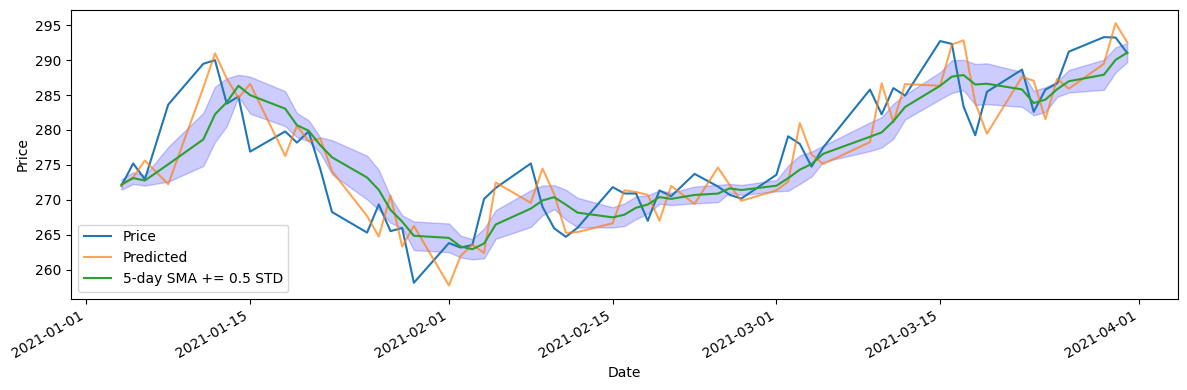

Results based on Bollinger Band:                  Capital Return  Remaining Stock  Last Closing Price
Daily Trading             58.66              0.0              291.02
Weekly Trading            21.20              0.0              291.02
Monthly Trading           51.11              0.0              291.02

Results based on SARIMAX predictions:                  Capital Return  Remaining Stock  Last Closing Price
Daily Trading             53.76              0.0              291.02
Weekly Trading          -292.59              1.0              291.02
Monthly Trading           51.11              0.0              291.02
None
--------------------------------------------------------------------------
Process time series data for Turkey - Koc Holding AS (KCHOL)...
Make predictions and calculate capital return...
Result:


100%|██████████| 63/63 [00:37<00:00,  1.70it/s]


SARIMAX model:
    Mean Squared Error: 0.2952
    Mean Absolute Percentage Error: 0.0181
    R2 Score: 0.7825
    


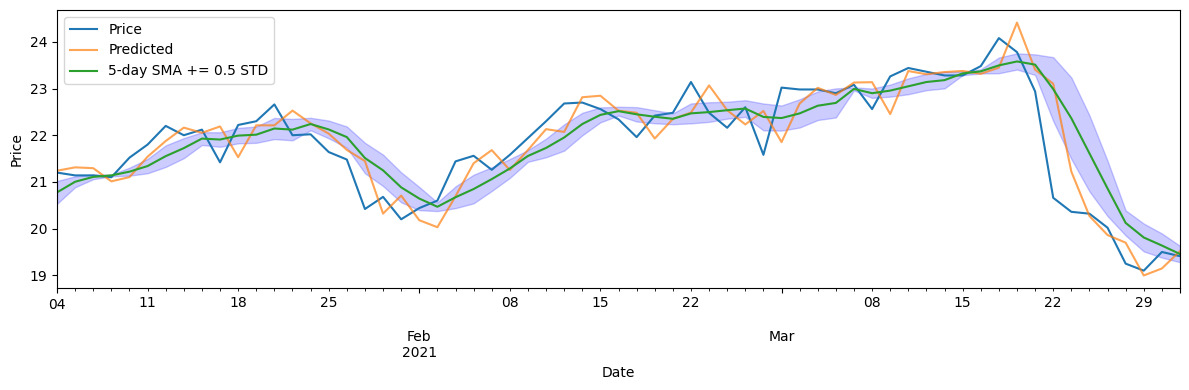

Results based on Bollinger Band:                  Capital Return  Remaining Stock  Last Closing Price
Daily Trading              3.60              0.0               19.41
Weekly Trading           -19.40              1.0               19.10
Monthly Trading           -3.76              0.0               19.10

Results based on SARIMAX predictions:                  Capital Return  Remaining Stock  Last Closing Price
Daily Trading              4.82              0.0               19.41
Weekly Trading             1.60              0.0               19.10
Monthly Trading           -3.76              0.0               19.10
None
--------------------------------------------------------------------------
Process time series data for Egypt - Medinet Nasr Housing (MNHD)...
Make predictions and calculate capital return...
Result:


100%|██████████| 62/62 [00:43<00:00,  1.42it/s]


SARIMAX model:
    Mean Squared Error: 0.0027
    Mean Absolute Percentage Error: 0.0109
    R2 Score: 0.7877
    


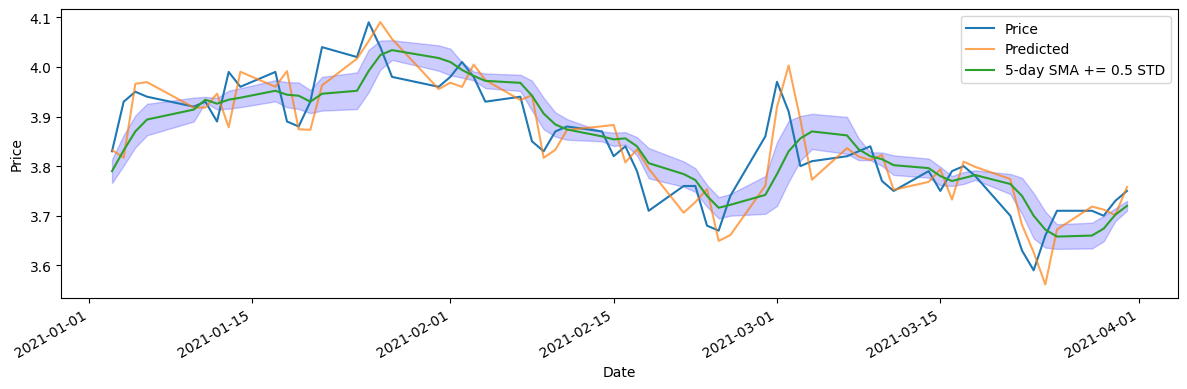

Results based on Bollinger Band:                  Capital Return  Remaining Stock  Last Closing Price
Daily Trading             -4.49              1.0                3.75
Weekly Trading            -0.54              0.0                3.73
Monthly Trading            0.00              0.0                3.73

Results based on SARIMAX predictions:                  Capital Return  Remaining Stock  Last Closing Price
Daily Trading             -0.38              0.0                3.75
Weekly Trading            -0.30              0.0                3.73
Monthly Trading            0.00              0.0                3.73
None
--------------------------------------------------------------------------
Process time series data for Brazil - Minerva SA/Brazil (BEEF3)...
Make predictions and calculate capital return...
Result:


100%|██████████| 60/60 [00:47<00:00,  1.27it/s]


SARIMAX model:
    Mean Squared Error: 0.0597
    Mean Absolute Percentage Error: 0.0204
    R2 Score: 0.3256
    


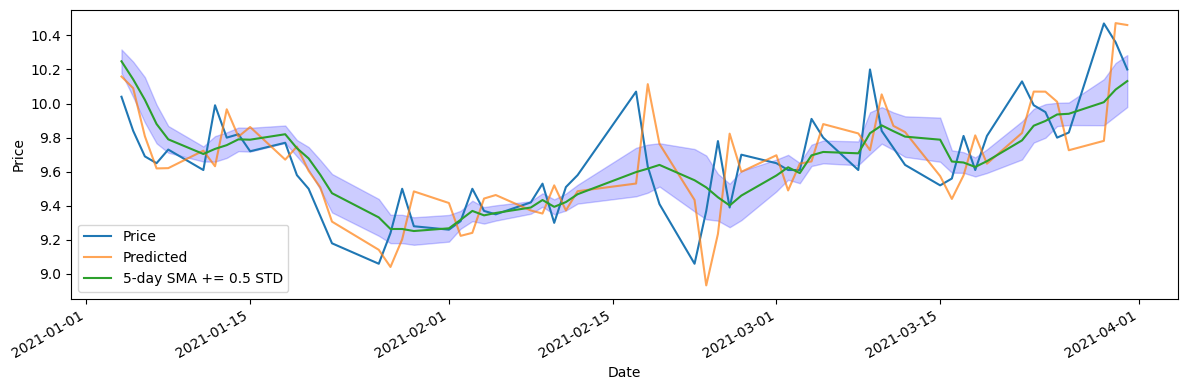

Results based on Bollinger Band:                  Capital Return  Remaining Stock  Last Closing Price
Daily Trading              4.36              0.0               10.20
Weekly Trading             0.40              0.0                9.80
Monthly Trading            0.28              0.0                9.91

Results based on SARIMAX predictions:                  Capital Return  Remaining Stock  Last Closing Price
Daily Trading              3.29              0.0               10.20
Weekly Trading             1.75              0.0                9.80
Monthly Trading            0.28              0.0                9.91
None
--------------------------------------------------------------------------
Process time series data for Argentina - Pampa Energia SA (PAMP)...
Make predictions and calculate capital return...
Result:


100%|██████████| 60/60 [00:30<00:00,  2.00it/s]


SARIMAX model:
    Mean Squared Error: 3.7662
    Mean Absolute Percentage Error: 0.0191
    R2 Score: 0.7414
    


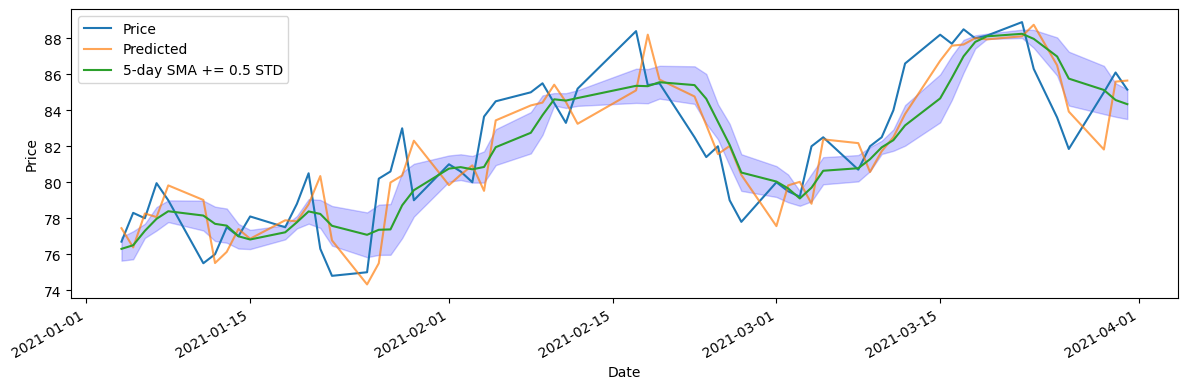

Results based on Bollinger Band:                  Capital Return  Remaining Stock  Last Closing Price
Daily Trading             25.75              0.0               85.15
Weekly Trading            40.30              0.0               83.60
Monthly Trading            0.00              0.0               79.20

Results based on SARIMAX predictions:                  Capital Return  Remaining Stock  Last Closing Price
Daily Trading              20.7              0.0               85.15
Weekly Trading             15.0              0.0               83.60
Monthly Trading             0.0              0.0               79.20
None
--------------------------------------------------------------------------
Process time series data for Colombia - Cementos Argos SA (CCB)...
Make predictions and calculate capital return...
Result:


100%|██████████| 61/61 [01:45<00:00,  1.73s/it]


SARIMAX model:
    Mean Squared Error: 9114.0126
    Mean Absolute Percentage Error: 0.0135
    R2 Score: 0.9136
    


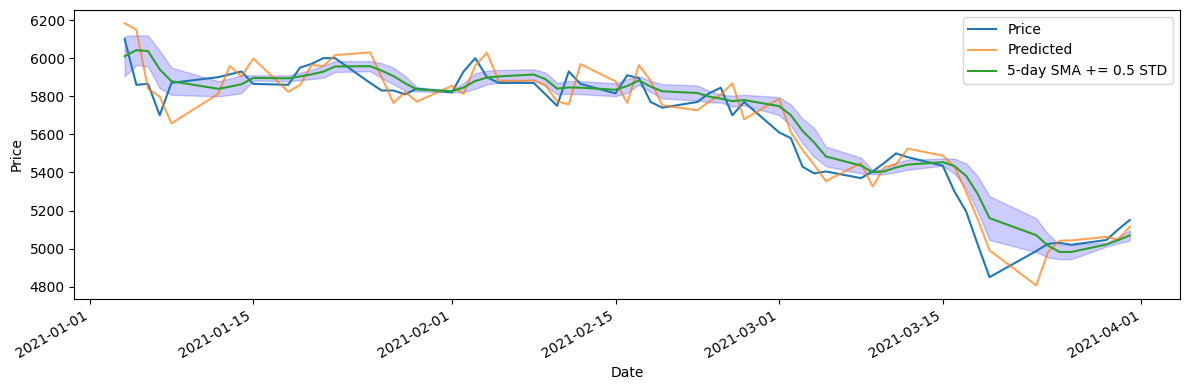

Results based on Bollinger Band:                  Capital Return  Remaining Stock  Last Closing Price
Daily Trading           -5420.0              1.0              5150.0
Weekly Trading          -5775.0              1.0              5150.0
Monthly Trading         -5100.0              1.0              5150.0

Results based on SARIMAX predictions:                  Capital Return  Remaining Stock  Last Closing Price
Daily Trading               0.0              0.0              5150.0
Weekly Trading           -795.0              0.0              5150.0
Monthly Trading         -5100.0              1.0              5150.0
None
--------------------------------------------------------------------------
Process time series data for South Africa - Impala Platinum Holdings Ltd (IMPJ)...
Make predictions and calculate capital return...
Result:


100%|██████████| 62/62 [02:30<00:00,  2.43s/it]


SARIMAX model:
    Mean Squared Error: 466942.3205
    Mean Absolute Percentage Error: 0.023
    R2 Score: 0.939
    


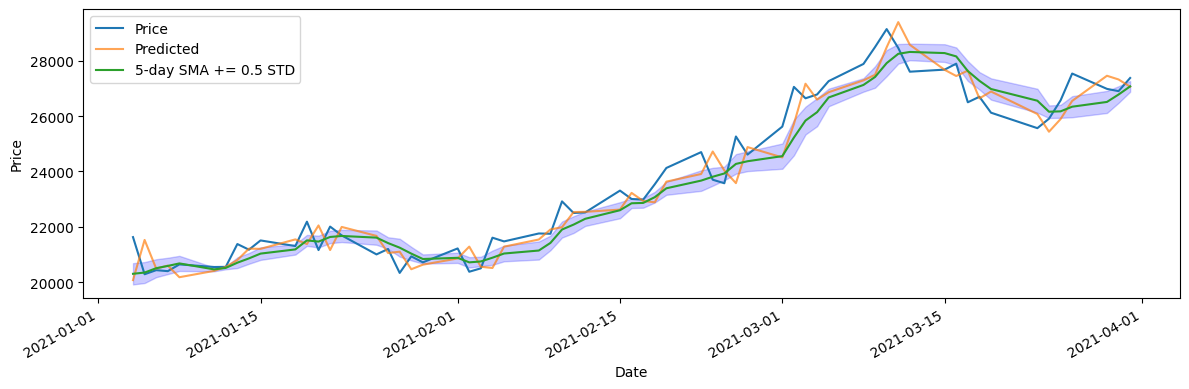

Results based on Bollinger Band:                  Capital Return  Remaining Stock  Last Closing Price
Daily Trading               0.0              0.0             27373.0
Weekly Trading              0.0              0.0             26898.0
Monthly Trading             0.0              0.0             26898.0

Results based on SARIMAX predictions:                  Capital Return  Remaining Stock  Last Closing Price
Daily Trading               0.0              0.0             27373.0
Weekly Trading              0.0              0.0             26898.0
Monthly Trading             0.0              0.0             26898.0
None
--------------------------------------------------------------------------
Process time series data for South Korea - Dongkuk Steel Mill Co Ltd (001230)...
Make predictions and calculate capital return...
Result:


100%|██████████| 69/69 [01:03<00:00,  1.09it/s]


SARIMAX model:
    Mean Squared Error: 111139.0457
    Mean Absolute Percentage Error: 0.0245
    R2 Score: 0.9422
    


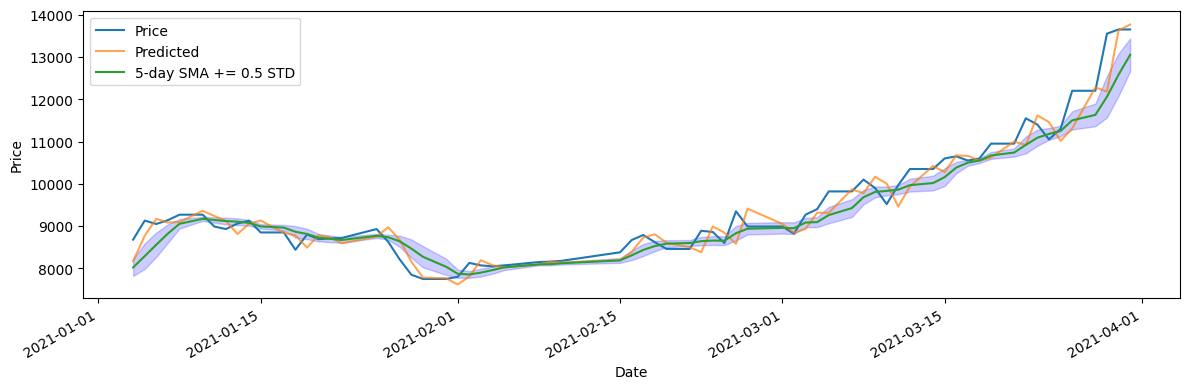

Results based on Bollinger Band:                  Capital Return  Remaining Stock  Last Closing Price
Daily Trading             450.0              0.0             13650.0
Weekly Trading            -70.0              0.0             12200.0
Monthly Trading          3220.0              0.0             11550.0

Results based on SARIMAX predictions:                  Capital Return  Remaining Stock  Last Closing Price
Daily Trading            -210.0              0.0             13650.0
Weekly Trading            600.0              0.0             12200.0
Monthly Trading          3220.0              0.0             11550.0
None
--------------------------------------------------------------------------


In [113]:
bollinger_band_windows = [5, 10, 20] # For daily, weekly, and monthly (e.g. 10, 20, 50)
bollinger_band_stds = [0.5, 0.5, 1]   # For daily, weekly, and monthly (e.g. 1.5, 2, 2.5)
initial_balance = 10000
initial_no_stock = 0
max_no_stock_to_trade = 1

for sheet_name in full_sheet_names:
    df = data_dfs[sheet_name]
    # print(df)
    print(f'Process time series data for {sheet_name}...')
    print('Make predictions and calculate capital return...')
    print('Result:')
    print(process_df(df, bollinger_band_windows, bollinger_band_stds,
                     plot_bollinger_band='Daily',
                     initial_balance=initial_balance,
                     initial_no_stock=initial_no_stock,
                     max_no_stock_to_trade=max_no_stock_to_trade,
                     print_result=False))
    print('--------------------------------------------------------------------------')

evaluate the results
also look at std of each stock, other things to explain the model performance
capital return also changes based on the period of SMA and the magnitude of std, etc.

there are so many uncertainties that are not accounted for or hidden, etc.


try to demonstrate why I made certain decisions on each step.

### <b>7. Conclusion</b>

things that worked well, not well.

(future/potential) applications


Bollinger Band is a known strategy that is proved to have worked fine to some extent.
With limited information about each stock and each trading date, it's practically impossible to build a very accurate prediction model, not to mention predicting stock price is notoriously difficult.